In [1]:
import tensorflow as tf
import numpy as np

In [2]:
from tensorflow.keras.datasets import imdb
(x_train_all, y_train_all), (x_test, y_test) = imdb.load_data(skip_top=20, num_words=100)

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do t

In [3]:
print(x_train_all.shape, y_train_all.shape)

(25000,) (25000,)


In [4]:
print(x_train_all[0])

[2, 2, 22, 2, 43, 2, 2, 2, 2, 65, 2, 2, 66, 2, 2, 2, 36, 2, 2, 25, 2, 43, 2, 2, 50, 2, 2, 2, 35, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 39, 2, 2, 2, 2, 2, 2, 38, 2, 2, 2, 2, 50, 2, 2, 2, 2, 2, 2, 22, 2, 2, 2, 2, 2, 22, 71, 87, 2, 2, 43, 2, 38, 76, 2, 2, 2, 2, 22, 2, 2, 2, 2, 2, 2, 2, 2, 2, 62, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 66, 2, 33, 2, 2, 2, 2, 38, 2, 2, 25, 2, 51, 36, 2, 48, 25, 2, 33, 2, 22, 2, 2, 28, 77, 52, 2, 2, 2, 2, 82, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 36, 71, 43, 2, 2, 26, 2, 2, 46, 2, 2, 2, 2, 2, 2, 88, 2, 2, 2, 2, 98, 32, 2, 56, 26, 2, 2, 2, 2, 2, 2, 2, 22, 21, 2, 2, 26, 2, 2, 2, 30, 2, 2, 51, 36, 28, 2, 92, 25, 2, 2, 2, 65, 2, 38, 2, 88, 2, 2, 2, 2, 2, 2, 2, 2, 32, 2, 2, 2, 2, 2, 32]


In [5]:
for i in range(len(x_train_all)):
    x_train_all[i] = [w for w in x_train_all[i] if w>2]

In [6]:
word_to_index = imdb.get_word_index()
word_to_index["movie"]

17

In [7]:
index_to_word = {word_to_index[k]: k for k in word_to_index}

for w in x_train_all[0]:
    print(index_to_word[w - 3], end=" ")

film just story really they you just there an from so there film film were great just so much film would really at so you what they if you at film have been good also they were just are out because them all up are film but are be what they have don't you story so because all all 

In [8]:
print(len(x_train_all[0]), len(x_train_all[1]))

59 32


In [9]:
print(y_train_all[:10])

[1 0 0 1 0 0 1 0 1 0]


In [10]:
np.random.seed(42)

random_index = np.random.permutation(25000)

x_train = x_train_all[random_index[:20000]]
y_train = y_train_all[random_index[:20000]]
x_val = x_train_all[random_index[20000:]]
y_val = y_train_all[random_index[20000:]]

In [11]:
from tensorflow.keras.preprocessing import sequence

maxlen = 100
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_seq = sequence.pad_sequences(x_val, maxlen=maxlen)

In [12]:
print(x_train_seq.shape, x_val_seq.shape)

(20000, 100) (5000, 100)


In [13]:
print(x_train_seq[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0 35 40 27 28 40 22 83 31 85 45
 24 23 31 70 31 76 30 98 32 22 28 51 75 56 30 33 97 53 38 46 53 74 31 35
 23 34 22 58]


In [14]:
from tensorflow.keras.utils import to_categorical

x_train_onehot = to_categorical(x_train_seq)
x_val_onehot = to_categorical(x_val_seq)

In [15]:
print(x_train_onehot.shape)

(20000, 100, 100)


In [16]:
print(x_train_onehot.nbytes)

800000000


In [17]:
class RecurrentNetwork:
    
    def __init__(self, n_cells=10, batch_size=32, learning_rate=0.1):
        self.n_cells = n_cells
        self.w1h = None
        self.w1x = None
        self.batch_size = batch_size
        self.b1 = None
        self.w2 = None
        self.b2 = None
        self.h = None
        self.losses = []
        self.val_losses = []
        self.lr = learning_rate
        
    def forpass(self, x):
        self.h = [np.zeros((x.shape[0], self.n_cells))]
        seq = np.swapaxes(x,0,1)
        for i in seq:
            z1 = np.dot(i, self.w1x) + np.dot(self.h[-1], self.w1h) + self.b1
            h = np.tanh(z1)
            self.h.append(h)
            z2 = np.dot(h, self.w2) + self.b2
            
        return z2
        
    def backprop(self, x, err):
        
        m = len(x)
        
        w2_grad = np.dot(self.h[-1].T, err) / m
        
        b2_grad = np.sum(err) / m
        
        seq = np.swapaxes(x, 0, 1)
        
        w1h_grad = w1x_grad = b1_grad = 0
        
        err_to_cell = np.dot(err, self.w2.T) * (1 - self.h[-1] ** 2)
        
        for x, h in zip(seq[::-1][:10], self.h[:-1][::-1][:10]):
            w1h_grad += np.dot(h.T, err_to_cell)
            w1x_grad += np.dot(x.T, err_to_cell)
            b1_grad += np.sum(err_to_cell, axis=0)
            err_to_cell = np.dot(err_to_cell, self.w1h) * (1 - h ** 2)
        
        w1h_grad /= m
        w1x_grad /= m
        b1_grad /= m
        
        return w1h_grad, w1x_grad, b1_grad, w2_grad, b2_grad
    
    def sigmoid(self, z):
        
        z = np.clip(z, -100, None)
        a = 1 / (1 + np.exp(-z))
        
        return a
    
    def init_weights(self, n_features, n_classes):
        
        orth_init = tf.initializers.Orthogonal()
        
        glorot_init = tf.initializers.GlorotUniform()
        
        
        self.w1h = orth_init((self.n_cells, self.n_cells)).numpy()
        
        self.w1x = glorot_init((n_features, self.n_cells)).numpy()
        
        self.b1 = np.zeros(self.n_cells)
        
        self.w2 = glorot_init((self.n_cells, self.n_cells)).numpy()
        
        self.b2 =  np.zeros(n_classes)
    
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        
        y = y.reshape(-1, 1)
        
        y_val = y_val.reshape(-1,1)
        
        np.random.seed(42)
        
        self.init_weights(x.shape[2], y.shape[1])
                
        for i in range(epochs):
            print("epochs", i, end=" ")
            
            batch_losses = []
            for x_batch, y_batch in self.gen_batch(x,y):
                
                print(".", end="")
                a = self.training(x_batch, y_batch)
                
                a = np.clip(a, 1e-10, 1-1e-10)
                
                loss = np.mean(-(y_batch * np.log(a) + (1 - y_batch) * np.log(1-a)))
                
                batch_losses.append(loss)
                
            print( )
            
            self.losses.append(np.mean(batch_losses))
            
            self.update_val_loss(x_val, y_val)
    
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size
        
        if length % self.batch_size:
            bins+=1
        
        indexes = np.random.permutation(np.arange(len(x)))
        x = x[indexes]
        y = y[indexes]
        
        for i in range(bins):
            
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            
            yield x[start:end], y[start:end]
    
    def training(self, x, y):
        
        m = len(x)
        
        z = self.forpass(x)
        
        a = self.sigmoid(z)
        
        err = -(y - a)
        
        w1h_grad, w1x_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        
        self.w1h -= self.lr * w1h_grad
        
        self.w1x -= self.lr * w1x_grad
        
        self.b1 -= self.lr * b1_grad
        
        self.w2 -= self.lr * w2_grad
        
        self.b2 -= self.lr * b2_grad
        
        return a
        
    def predict(self, x):
        
        z = self.forpass(x)
        return z > 0
    
    def score(self, x, y):
        
        return np.mean(self.predict(x) == y.reshape(-1,1))
    
    def update_val_loss(self, x_val, y_val):
        
        z = self.forpass(x_val)
        
        a = self.sigmoid(z)
        
        a = np.clip(a, 1e-10, 1-1e-10)
        
        val_loss = np.mean(-(y_val * np.log(a) + (1 - y_val) * np.log(1-a)))
        
        self.val_losses.append(val_loss)

In [18]:
rn = RecurrentNetwork(n_cells=32, batch_size=32, learning_rate=0.01)

In [19]:
rn.fit(x_train_onehot, y_train, x_val=x_val_onehot, y_val=y_val, epochs=20)

epochs 0 .................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
epochs 1 ....................................................................................................................................................................................................................................................................................................................................................................

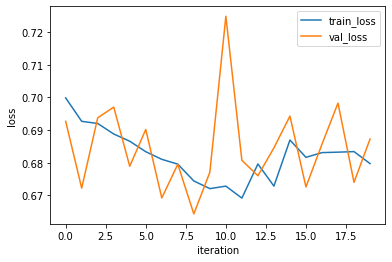

In [20]:
import matplotlib.pyplot as plt

plt.plot(rn.losses)
plt.plot(rn.val_losses)
plt.ylabel("loss")
plt.xlabel("iteration")
plt.legend(["train_loss", "val_loss"])
plt.show()

In [21]:
rn.score(x_val_onehot, y_val)

0.543425

In [22]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, SimpleRNN

In [23]:
model = tf.keras.Sequential()
model.add(SimpleRNN(32, input_shape=(100,100)))

model.add(Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 32)                4256      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(optimizer="sgd", loss="binary_crossentropy", metrics=["accuracy"])

In [25]:
history = model.fit(x_train_onehot, y_train, epochs=20, batch_size=32, validation_data=(x_val_onehot, y_val))

Epoch 1/20
625/625 [==============================] - 41s 62ms/step - loss: 0.6995 - accuracy: 0.5077 - val_loss: 0.6940 - val_accuracy: 0.5094
Epoch 2/20
625/625 [==============================] - 38s 61ms/step - loss: 0.6891 - accuracy: 0.5339 - val_loss: 0.6805 - val_accuracy: 0.5630
Epoch 3/20
625/625 [==============================] - 38s 62ms/step - loss: 0.6645 - accuracy: 0.5990 - val_loss: 0.6393 - val_accuracy: 0.6474
Epoch 4/20
625/625 [==============================] - 39s 62ms/step - loss: 0.6384 - accuracy: 0.6350 - val_loss: 0.6286 - val_accuracy: 0.6520
Epoch 5/20
625/625 [==============================] - 39s 62ms/step - loss: 0.6215 - accuracy: 0.6538 - val_loss: 0.6086 - val_accuracy: 0.6736
Epoch 6/20
625/625 [==============================] - 38s 62ms/step - loss: 0.6104 - accuracy: 0.6694 - val_loss: 0.6493 - val_accuracy: 0.6226
Epoch 7/20
625/625 [==============================] - 39s 62ms/step - loss: 0.6010 - accuracy: 0.6799 - val_loss: 0.6392 - val_accuracy:

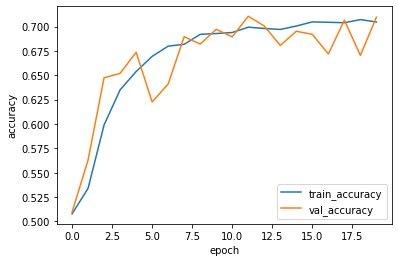

In [26]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train_accuracy", "val_accuracy"])
plt.show()

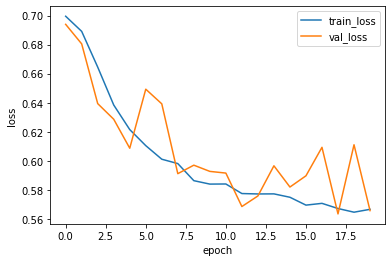

In [27]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train_loss", "val_loss"])
plt.show()

In [28]:
loss, accuracy = model.evaluate(x_val_onehot, y_val, verbose=1)

157/157 [==============================] - 4s 27ms/step - loss: 0.5656 - accuracy: 0.7096


In [29]:
print(accuracy)

0.7095999717712402


In [30]:
from tensorflow.keras.layers import Embedding

In [31]:
(x_train_all, y_train_all), (x_test, y_test) = imdb.load_data(skip_top=20, num_words=1000)

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do t

In [32]:
for i in range(len(x_train_all)):
    x_train_all[i] = [w for w in x_train_all[i] if w>2]
    
x_train = x_train_all[random_index[:20000]]
y_train = y_train_all[random_index[:20000]]
x_val = x_train_all[random_index[20000:]]
y_val = y_train_all[random_index[20000:]]

In [33]:
maxlen = 100
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_seq = sequence.pad_sequences(x_val, maxlen=maxlen)

In [34]:
model_ebd = tf.keras.Sequential()
model_ebd.add(Embedding(1000,32))

model_ebd.add(SimpleRNN(8))
model_ebd.add(Dense(1, activation="sigmoid"))

model_ebd.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          32000     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 8)                 328       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 32,337
Trainable params: 32,337
Non-trainable params: 0
_________________________________________________________________


In [35]:
model_ebd.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [36]:
history = model_ebd.fit(x_train_seq, y_train, epochs=10,batch_size=32, validation_data=(x_val_seq, y_val))

Epoch 1/10
625/625 [==============================] - 66s 104ms/step - loss: 0.5336 - accuracy: 0.7297 - val_loss: 0.4592 - val_accuracy: 0.7948
Epoch 2/10
625/625 [==============================] - 64s 102ms/step - loss: 0.4044 - accuracy: 0.8299 - val_loss: 0.4357 - val_accuracy: 0.8014
Epoch 3/10
625/625 [==============================] - 64s 102ms/step - loss: 0.3492 - accuracy: 0.8583 - val_loss: 0.3913 - val_accuracy: 0.8314
Epoch 4/10
625/625 [==============================] - 64s 102ms/step - loss: 0.3147 - accuracy: 0.8736 - val_loss: 0.3945 - val_accuracy: 0.8294
Epoch 5/10
494/625 [======================>.......] - ETA: 12s - loss: 0.2822 - accuracy: 0.8880

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



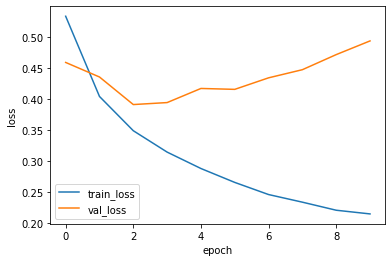

In [37]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train_loss", "val_loss"])
plt.show()

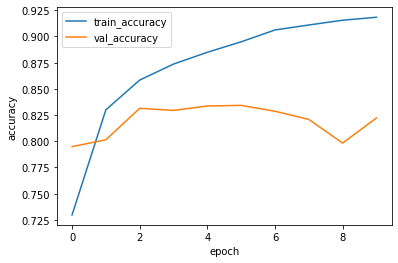

In [38]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train_accuracy", "val_accuracy"])
plt.show()

In [39]:
loss, accuracy = model_ebd.evaluate(x_val_seq, y_val, verbose=1)
print(accuracy)

157/157 [==============================] - 5s 31ms/step - loss: 0.4939 - accuracy: 0.8222
0.8222000002861023


In [40]:
from tensorflow.keras.layers import LSTM

model_lstm = tf.keras.Sequential()
model_lstm.add(Embedding(1000,32))

model_lstm.add(LSTM(8))
model_lstm.add(Dense(1, activation="sigmoid"))

model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          32000     
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 1312      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 33,321
Trainable params: 33,321
Non-trainable params: 0
_________________________________________________________________


In [41]:
model_lstm.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [42]:
history = model_lstm.fit(x_train_seq, y_train, epochs=10, batch_size=32, validation_data=(x_val_seq, y_val))

Epoch 1/10
625/625 [==============================] - 15s 20ms/step - loss: 0.4342 - accuracy: 0.8026 - val_loss: 0.3680 - val_accuracy: 0.8398
Epoch 2/10
625/625 [==============================] - 12s 20ms/step - loss: 0.3358 - accuracy: 0.8594 - val_loss: 0.3581 - val_accuracy: 0.8428
Epoch 3/10
625/625 [==============================] - 12s 20ms/step - loss: 0.3132 - accuracy: 0.8677 - val_loss: 0.3807 - val_accuracy: 0.8410
Epoch 4/10
625/625 [==============================] - 12s 20ms/step - loss: 0.2979 - accuracy: 0.8747 - val_loss: 0.3579 - val_accuracy: 0.8408
Epoch 5/10
625/625 [==============================] - 12s 20ms/step - loss: 0.2852 - accuracy: 0.8814 - val_loss: 0.3620 - val_accuracy: 0.8422
Epoch 6/10
625/625 [==============================] - 12s 20ms/step - loss: 0.2729 - accuracy: 0.8860 - val_loss: 0.3754 - val_accuracy: 0.8336
Epoch 7/10
625/625 [==============================] - 12s 20ms/step - loss: 0.2634 - accuracy: 0.8910 - val_loss: 0.3779 - val_accuracy:

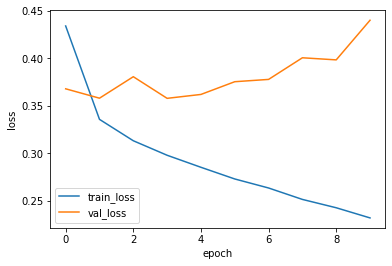

In [43]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train_loss", "val_loss"])
plt.show()

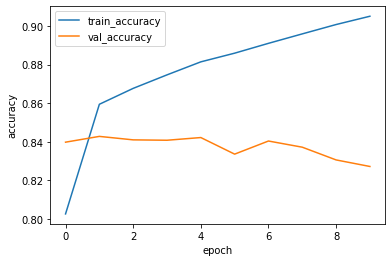

In [44]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train_accuracy", "val_accuracy"])
plt.show()

In [45]:
loss, accuracy = model_lstm.evaluate(x_val_seq, y_val, verbose=1)
print(accuracy)

157/157 [==============================] - 2s 14ms/step - loss: 0.4402 - accuracy: 0.8272
0.8271999955177307
